In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import glob

from scipy.stats import pearsonr
print(tf.__version__)
np.random.seed(422)

from sklearn.model_selection import train_test_split
from scipy import stats
from subprocess import run, check_output
import os
import random

import time
import seaborn as sns

2.7.0


In [21]:
def custom_activation(x):
    return (K.sigmoid(0.5*x) + 1)

In [22]:
def heteroscedastic_loss(true, pred):
    """ Heteroskedastic loss function."""
    params = pred.shape[1]//2
    point = pred[:, :params]
    var = pred[:, params:]
    precision = 1 / var
    return keras.backend.sum(precision * (true - point) ** 2. + keras.backend.log(var), -1)

In [23]:
def create_model(n_params, channels, filters, batchnorm = False, training = True):
    
    inp = keras.Input(shape=(None, channels))
    x = tf.keras.layers.Conv1D(filters[0], kernel_size=1, strides=1, activation='relu')(inp)  
    
    skipFunc_1 = tf.keras.layers.Conv1D(filters[0], kernel_size=1)(x)
    skipFunc_1 = tf.keras.layers.BatchNormalization(axis=2, epsilon=bnEps,momentum=bnMom)(skipFunc_1)
  
    x = tf.keras.layers.Conv1D(filters[0] , kernel_size=1 , activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters[0], kernel_size = 3, strides = 1 , use_bias=False , padding = "same")(x)
    x = tf.keras.layers.add([x, skipFunc_1])
    x = tf.keras.layers.Activation("relu")(x)
    
    skipFunc_2 = tf.keras.layers.Conv1D(filters[0], kernel_size=1)(x)
    skipFunc_2 = tf.keras.layers.BatchNormalization(axis=2, epsilon=bnEps,momentum=bnMom)(skipFunc_2)
    
    x = tf.keras.layers.Conv1D(filters[0] , kernel_size=1 , activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters[0], kernel_size = 3, strides = 1 , use_bias=False,padding = "same")(x)
    x = tf.keras.layers.add([x, skipFunc_2])
    x = tf.keras.layers.Activation("relu")(x)
   
    skipFunc_3 = tf.keras.layers.Conv1D(filters[1], kernel_size=1)(x)
    skipFunc_3 = tf.keras.layers.BatchNormalization(axis=2, epsilon=bnEps,momentum=bnMom)(skipFunc_3)
    
    x = tf.keras.layers.Conv1D(filters[1] , kernel_size=1, activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters[1], kernel_size = 3, strides = 1 , use_bias=False,padding = "same")(x)
    x = tf.keras.layers.add([x, skipFunc_3])
    x = tf.keras.layers.Activation("relu")(x)

    skipFunc_4 = tf.keras.layers.Conv1D(filters[1], kernel_size=1)(x)
    skipFunc_4 = tf.keras.layers.BatchNormalization(axis=2, epsilon=bnEps,momentum=bnMom)(skipFunc_4)
    
    x = tf.keras.layers.Conv1D(filters[1] , kernel_size=1 , activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters[1], kernel_size = 3, strides = 1 , use_bias=False,padding = "same")(x)
    x = tf.keras.layers.add([x, skipFunc_4])
    x = tf.keras.layers.Activation("relu")(x)
     
    x = keras.layers.GlobalAveragePooling1D()(x)
    
    dens1 = keras.layers.Dense(250, activation='relu')(x)
    dens2 = keras.layers.Dense(100, activation='relu')(dens1)
    dens3 = keras.layers.Dense(50, activation='relu')(dens2)

    mean = keras.layers.Dense(n_params)(dens3)
    var = keras.layers.Dense(n_params, activation='softplus')(x)
    out = keras.layers.Concatenate()([mean, var])
    model = keras.Model(inp, out)
    return model

In [24]:
def plot_analytic_vs_est(true, pred, names ,log=True, plot_abline=True,show=True,filename='figure.png',path=None):
    """Create a 3x2 plot as in paper."""
    
    def abline(slope, intercept, ax):
        x = np.array(ax.get_xlim())
        y = intercept + slope * x
        return x, y 
    
    font = {'fontname':'Arial', 'fontsize': 16}
    textfont = {'fontname':'Arial', 'fontsize': 11}
    axisfont = {'fontname':'Arial', 'fontsize': 12}
    

    f, axarr = plt.subplots(2, 2, figsize=(10, 12))
    
    
    for i, ax in enumerate(axarr.flat):
        
       
        if i == (pred.shape[1]//2):
            print(i)
            break

        ax.plot(true[:,i], pred[:,i],marker='o', linewidth=0,alpha=0.1,color='red')

        cor = np.round(np.corrcoef(true[:,i],pred[:,i])[0,1],2)
        r_squared = np.round(1 -(np.var(true[:,i] - pred[:,i])/np.var(true[:,i])),2)
       
        ax.text(0.2,0.9,'r: ' + str(cor),ha='center', va='center', transform=ax.transAxes,**textfont)
        ax.text(0.2,0.8,'R2: ' + str(r_squared),ha='center', va='center', transform=ax.transAxes,**textfont)
        
        if plot_abline:
            ax.plot(*abline(1, 0, ax),color='black')
        else:
            ax.plot(*best_line_fit(true[:,i], pred[:,i]))
        if i == 0:
            ax.set_xlabel('True',**axisfont)
            ax.set_ylabel('Estimated',**axisfont)
            
        ax.set_title(names[i],**font)
        
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        
    plt.savefig(filename) 
    if show:
        plt.show()
        
    return None

## Defining the structure of the network

In [25]:
paramnames = ['a', 'v', 'zr','t0']

filters = [64,128,128,512]
nchannels = 1
optimizer = 'adam'


bnEps = 2e-5
bnMom = 0.9
reg = 0.0001

# Batch size:
batchsize = 64

checkpoint_path = "trained_ResNet_DDM.hdf5"

In [26]:
keras.backend.clear_session()
Resnet = create_model(n_params=len(paramnames),channels=nchannels,filters=filters)

Resnet.compile(optimizer=optimizer, loss=heteroscedastic_loss)
earlystopper = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)
checkpointer = keras.callbacks.ModelCheckpoint(checkpoint_path,save_best_only=True,verbose=1)
Resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, None, 64)     128         ['input_1[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, None, 64)     4160        ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, None, 64)     4160        ['conv1d[0][0]']                 
                                                                                              

## Loading training data

In [27]:
n_file = 140
X_train = np.empty((n_file*200, 240))
y_train = np.empty((n_file*200, 5))

for i in range(n_file):
    x_temp = np.load('Data_Generation/DataSet/X_train' + str(i) + '.npy')
    X_train[i*200:(i+1)*200, :] = x_temp
    

for i in range(n_file):
    y_temp = np.load('Data_Generation/DataSet/y_train' + str(i) + '.npy')
    y_train[i*200:(i+1)*200, :] = y_temp
    
y_train = y_train[:, [0, 1, 2, 3]]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.005, random_state=0)

## Training the network

In [29]:
history = Resnet.fit(X_train, 
                    y_train, 
                    batch_size=batchsize,
                    epochs=20, 
                    validation_split=0.01,
                    callbacks=[checkpointer])


Epoch 1/20
431/431 [==============================] - ETA: 0s - loss: -2.3007
Epoch 00001: val_loss improved from inf to -3.97237, saving model to trained_ResNet_DDM.hdf5
431/431 [==============================] - 82s 188ms/step - loss: -2.3007 - val_loss: -3.9724
Epoch 2/20
431/431 [==============================] - ETA: 0s - loss: -4.9677
Epoch 00002: val_loss improved from -3.97237 to -5.01266, saving model to trained_ResNet_DDM.hdf5
431/431 [==============================] - 81s 188ms/step - loss: -4.9677 - val_loss: -5.0127
Epoch 3/20
431/431 [==============================] - ETA: 0s - loss: -6.0446
Epoch 00003: val_loss improved from -5.01266 to -6.51034, saving model to trained_ResNet_DDM.hdf5
431/431 [==============================] - 82s 189ms/step - loss: -6.0446 - val_loss: -6.5103
Epoch 4/20
431/431 [==============================] - ETA: 0s - loss: -6.6439
Epoch 00004: val_loss improved from -6.51034 to -6.54903, saving model to trained_ResNet_DDM.hdf5
431/431 [==========

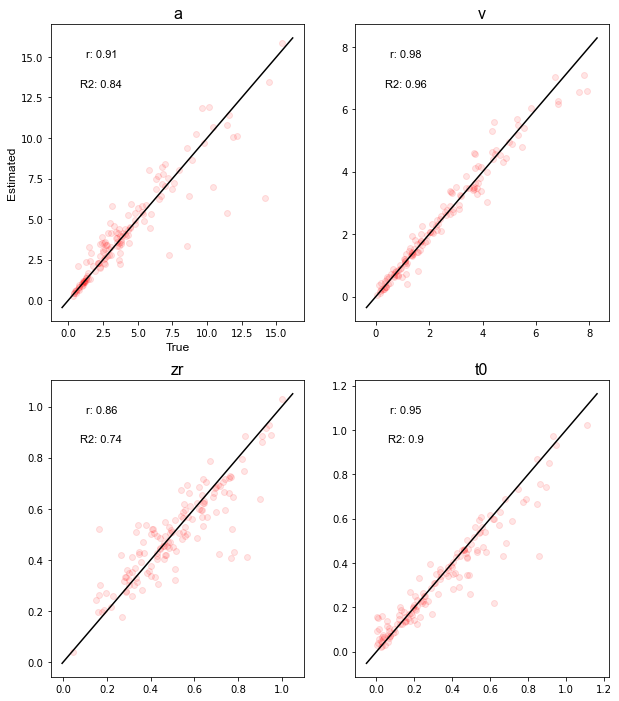

In [31]:
y_test = y_test[:, [0, 1, 2, 3]]

pred = Resnet.predict(X_test)

plot_analytic_vs_est(y_test,
                     pred,
                     log=False,
                     names=paramnames,
                     show=True,
                     filename='Resnet_X_train_DDM.png')

In [ ]:
Resnet.save("")